# Trabalho Final de IA: Previsão do Nível do Rio Itajaí com Regressão Linear

## Objetivos:
- Análise exploratória dos dados
- Pré-processamento e limpeza
- Treinamento de modelos de regressão linear
- Avaliação e comparação de modelos

## Importação das Bibliotecas

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

# Configuração dos gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Leitura e Análise Inicial dos Dados

In [36]:
# Carregar o dataset
df = pd.read_csv("dados_rio_e_chuva.csv")

print(f"Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas")
print("\nPrimeiras 5 linhas:")
print(df.head())

Dataset carregado com 65408 linhas e 5 colunas

Primeiras 5 linhas:
  NivelRiodoSul NívelItuporanga ChuvaItuporanga NívelTaió ChuvaTaió
0         170,0            30,0             3,0      98,0       0,0
1         170,0            39,0            12,0      98,0       0,0
2         169,0            59,0            19,0      98,0       0,0
3         169,0            82,0             5,0      98,0       0,0
4         169,0            27,0             1,0      97,0       0,0


In [37]:
print("\nInformações gerais do dataset:")
print(df.info())

print("\nEstatísticas descritivas:")
print(df.describe())


Informações gerais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65408 entries, 0 to 65407
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   NivelRiodoSul    65408 non-null  object
 1   NívelItuporanga  65408 non-null  object
 2   ChuvaItuporanga  65408 non-null  object
 3   NívelTaió        65408 non-null  object
 4   ChuvaTaió        65408 non-null  object
dtypes: object(5)
memory usage: 2.5+ MB
None

Estatísticas descritivas:
       NivelRiodoSul NívelItuporanga ChuvaItuporanga NívelTaió ChuvaTaió
count          65408           65408           65408     65408     65408
unique           897             352              75       919        70
top            110,0            33,0             0,0      76,0       0,0
freq             812            2071           61897       899     62345


In [38]:
# Verificar valores faltantes
print("\nValores faltantes por coluna:")
print(df.isnull().sum())

# Verificar duplicatas
print(f"\nDuplicatas encontradas: {df.duplicated().sum()}")


Valores faltantes por coluna:
NivelRiodoSul      0
NívelItuporanga    0
ChuvaItuporanga    0
NívelTaió          0
ChuvaTaió          0
dtype: int64

Duplicatas encontradas: 25131


## Tratamento de Inconsistências

In [39]:
# Tratamento de inconsistências
print("\nTratando inconsistências...")

# Remover duplicatas se existirem
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print(f"Duplicatas removidas. Novo shape: {df.shape}")

# Convertendo as colunas para Numérico    
df = df.replace(',', '.', regex=True)

for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Tratar valores faltantes
if df.isnull().sum().sum() > 0:
    # Preencher valores faltantes com a média
    df = df.fillna(df.mean())
    print("Valores faltantes preenchidos com a média")

# Identificar colunas baseado na estrutura vista
colunas = df.columns.tolist()
print(f"\nColunas disponíveis: {colunas}")

# Assumindo que a primeira coluna é o nível do rio (variável alvo)
variavel_alvo = colunas[0]
variaveis_entrada = colunas[1:]

print(f"\nVariável alvo: {variavel_alvo}")
print(f"Variáveis de entrada: {variaveis_entrada}")


Tratando inconsistências...
Duplicatas removidas. Novo shape: (40277, 5)

Colunas disponíveis: ['NivelRiodoSul', 'NívelItuporanga', 'ChuvaItuporanga', 'NívelTaió', 'ChuvaTaió']

Variável alvo: NivelRiodoSul
Variáveis de entrada: ['NívelItuporanga', 'ChuvaItuporanga', 'NívelTaió', 'ChuvaTaió']


## Análise Exploratória

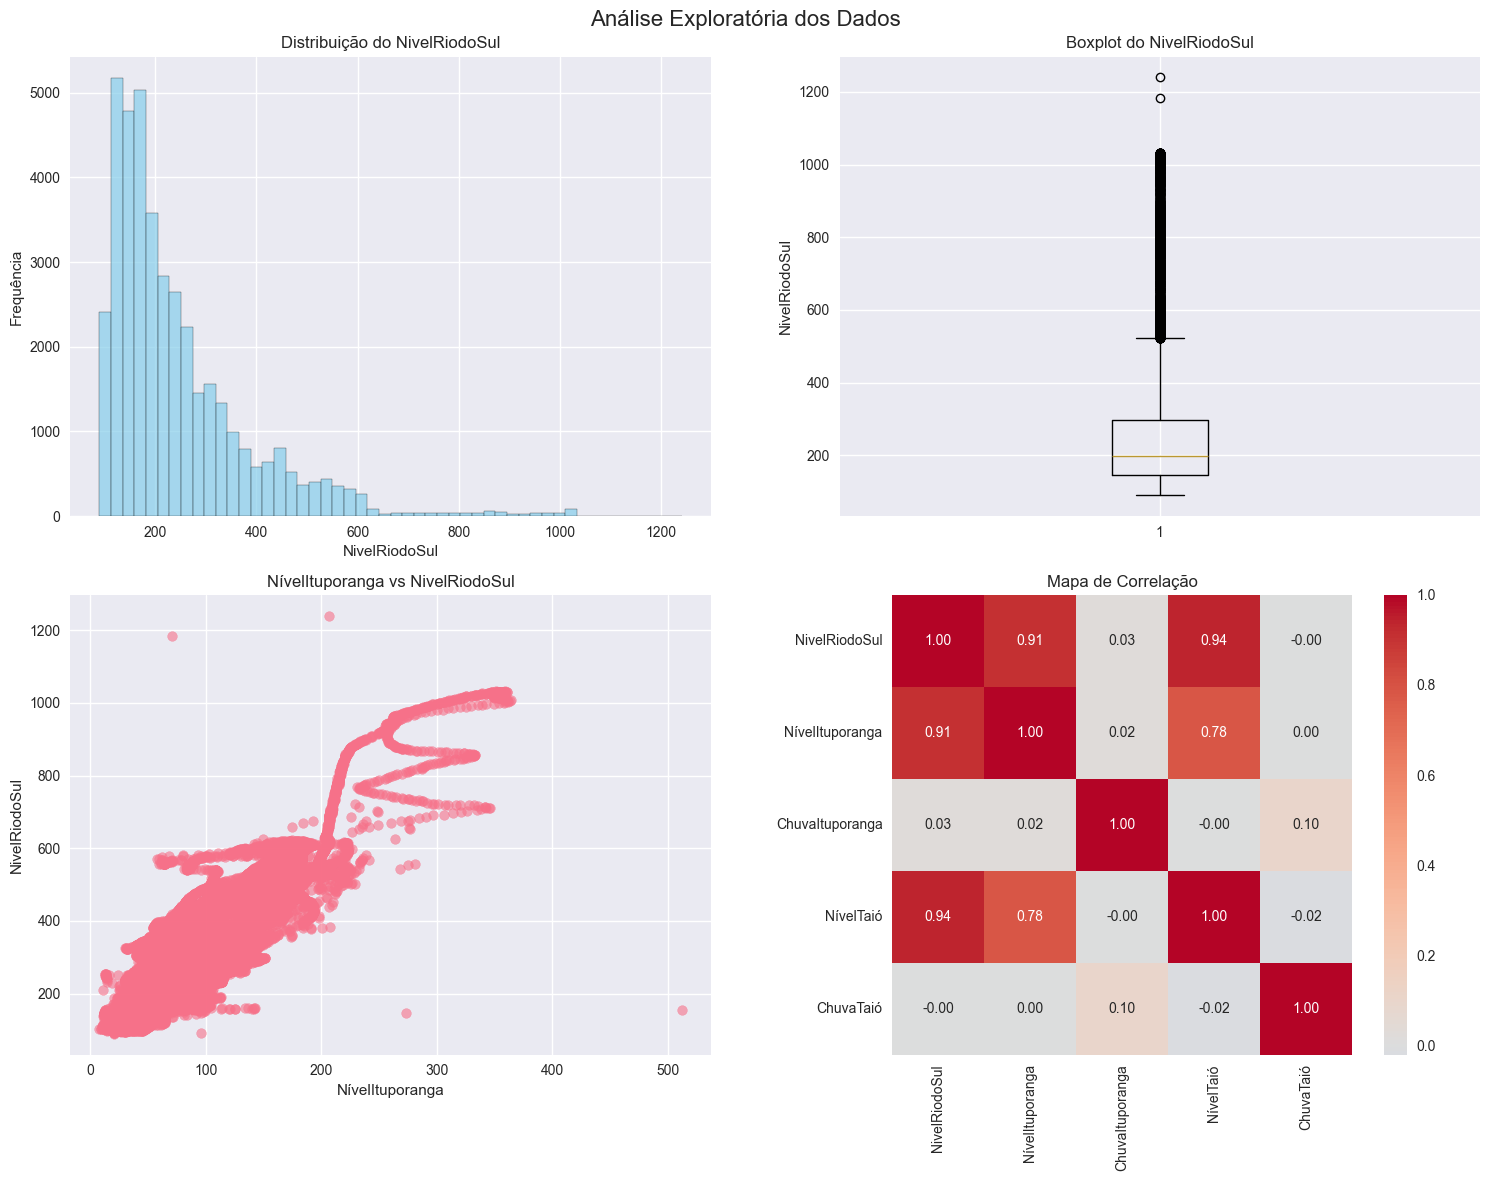

In [40]:
# Criar figura com subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análise Exploratória dos Dados', fontsize=16)

# Histograma da variável alvo
axes[0,0].hist(df[variavel_alvo], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title(f'Distribuição do {variavel_alvo}')
axes[0,0].set_xlabel(variavel_alvo)
axes[0,0].set_ylabel('Frequência')

# Boxplot da variável alvo
axes[0,1].boxplot(df[variavel_alvo])
axes[0,1].set_title(f'Boxplot do {variavel_alvo}')
axes[0,1].set_ylabel(variavel_alvo)

# Scatter plot entre variáveis (primeira variável de entrada vs alvo)
if len(variaveis_entrada) > 0:
    axes[1,0].scatter(df[variaveis_entrada[0]], df[variavel_alvo], alpha=0.6)
    axes[1,0].set_title(f'{variaveis_entrada[0]} vs {variavel_alvo}')
    axes[1,0].set_xlabel(variaveis_entrada[0])
    axes[1,0].set_ylabel(variavel_alvo)

# Heatmap de correlação
correlacao = df.corr()
sns.heatmap(correlacao, annot=True, cmap='coolwarm', center=0, 
            ax=axes[1,1], fmt='.2f', square=True)
axes[1,1].set_title('Mapa de Correlação')

plt.tight_layout()
plt.show()

In [41]:
# Análise de correlação detalhada
print("\nMatriz de Correlação:")
print(correlacao.round(3))

print(f"\nCorrelação com a variável alvo ({variavel_alvo}):")
correlacao_alvo = correlacao[variavel_alvo].abs().sort_values(ascending=False)
print(correlacao_alvo[1:]) 


Matriz de Correlação:
                 NivelRiodoSul  NívelItuporanga  ChuvaItuporanga  NívelTaió  \
NivelRiodoSul            1.000            0.907            0.026      0.939   
NívelItuporanga          0.907            1.000            0.021      0.781   
ChuvaItuporanga          0.026            0.021            1.000     -0.002   
NívelTaió                0.939            0.781           -0.002      1.000   
ChuvaTaió               -0.000            0.002            0.096     -0.021   

                 ChuvaTaió  
NivelRiodoSul       -0.000  
NívelItuporanga      0.002  
ChuvaItuporanga      0.096  
NívelTaió           -0.021  
ChuvaTaió            1.000  

Correlação com a variável alvo (NivelRiodoSul):
NívelTaió          0.938952
NívelItuporanga    0.906671
ChuvaItuporanga    0.026336
ChuvaTaió          0.000061
Name: NivelRiodoSul, dtype: float64


## Pré-processamento

In [42]:
# Separar features e target
X = df[variaveis_entrada]
y = df[variavel_alvo]

print(f"Shape das features: {X.shape}")
print(f"Shape do target: {y.shape}")

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Dados de treino: {X_train.shape[0]} amostras")
print(f"Dados de teste: {X_test.shape[0]} amostras")

# Normalizar/padronizar as variáveis
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dados padronizados com StandardScaler")

Shape das features: (40277, 4)
Shape do target: (40277,)
Dados de treino: 28193 amostras
Dados de teste: 12084 amostras
Dados padronizados com StandardScaler


## Treinamento do Modelo

In [43]:
# Função para avaliar modelo
def avaliar_modelo(y_true, y_pred, nome_modelo):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{nome_modelo}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

In [44]:
# Modelo 1: Todas as variáveis
modelo1 = LinearRegression()
modelo1.fit(X_train_scaled, y_train)
y_pred1 = modelo1.predict(X_test_scaled)

resultados_modelo1 = avaliar_modelo(y_test, y_pred1, "Modelo 1 - Todas as variáveis")


Modelo 1 - Todas as variáveis:
RMSE: 29.2715
MAE: 18.5490
R²: 0.9572


In [45]:
# Modelo 2: top 3 variáveis mais correlacionada
top_vars = correlacao_alvo[1:4].index.tolist()
print(f"\nTop 3 variáveis mais correlacionadas: {top_vars}")

X_train_top = X_train[top_vars]
X_test_top = X_test[top_vars]

X_train_top_scaled = scaler.fit_transform(X_train_top)
X_test_top_scaled = scaler.transform(X_test_top)

modelo2 = LinearRegression()
modelo2.fit(X_train_top_scaled, y_train)
y_pred2 = modelo2.predict(X_test_top_scaled)

resultados_modelo2 = avaliar_modelo(y_test, y_pred2, "Modelo 2 - Top 3 variáveis correlacionadas")


Top 3 variáveis mais correlacionadas: ['NívelTaió', 'NívelItuporanga', 'ChuvaItuporanga']

Modelo 2 - Top 3 variáveis correlacionadas:
RMSE: 29.2722
MAE: 18.5452
R²: 0.9572


In [46]:
# Modelo 3: Apenas a variável mais correlacionada
top_var = correlacao_alvo[1:2].index.tolist()
print(f"\nVariável mais correlacionada: {top_var}")

X_train_single = X_train[top_var]
X_test_single = X_test[top_var]

X_train_single_scaled = scaler.fit_transform(X_train_single)
X_test_single_scaled = scaler.transform(X_test_single)

modelo3 = LinearRegression()
modelo3.fit(X_train_single_scaled, y_train)
y_pred3 = modelo3.predict(X_test_single_scaled)

resultados_modelo3 = avaliar_modelo(y_test, y_pred3, "Modelo 3 - Variável mais correlacionada")


Variável mais correlacionada: ['NívelTaió']

Modelo 3 - Variável mais correlacionada:
RMSE: 48.5647
MAE: 30.2517
R²: 0.8822


## Comparação de Modelos

In [47]:
modelos_resultados = {
    'Modelo 1 (Todas)': resultados_modelo1,
    'Modelo 2 (Top 3)': resultados_modelo2,
    'Modelo 3 (Top 1)': resultados_modelo3
}

# Encontrar o melhor modelo
melhor_modelo = min(modelos_resultados, key=lambda x: modelos_resultados[x]['RMSE'])
print(f"\nMelhor modelo: {melhor_modelo}")
print(f"RMSE: {modelos_resultados[melhor_modelo]['RMSE']:.4f}")
print(f"R²: {modelos_resultados[melhor_modelo]['R2']:.4f}")

# Selecionar o modelo final
if melhor_modelo == 'Modelo 1 (Todas)':
    modelo_final = modelo1
    X_final_scaled = X_test_scaled
    scaler_final = scaler
    features_finais = variaveis_entrada
elif melhor_modelo == 'Modelo 2 (Top 3)':
    modelo_final = modelo2
    X_final_scaled = X_test_top_scaled
    scaler_final = scaler
    features_finais = top_vars
else:
    modelo_final = modelo3
    X_final_scaled = X_test_single_scaled
    scaler_final = scaler
    features_finais = top_var


Melhor modelo: Modelo 1 (Todas)
RMSE: 29.2715
R²: 0.9572


## Visualização dos Resultados

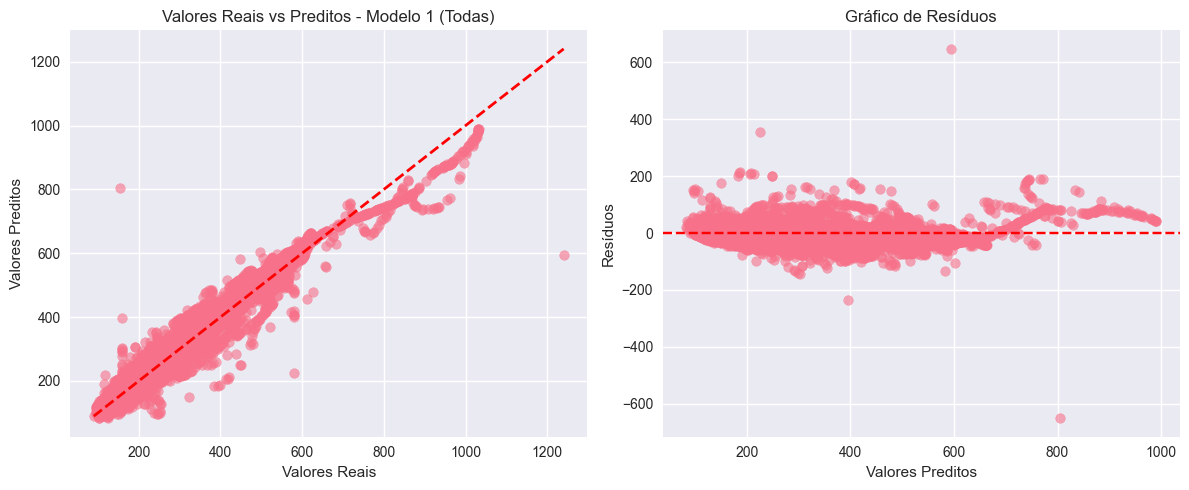

In [48]:
# Visualizar resultados do melhor modelo
plt.figure(figsize=(12, 5))

# Gráfico 1: Valores reais vs preditos
plt.subplot(1, 2, 1)
if melhor_modelo == 'Modelo 1 (Todas)':
    y_pred_final = y_pred1
elif melhor_modelo == 'Modelo 2 (Top 3)':
    y_pred_final = y_pred2
else:
    y_pred_final = y_pred3

plt.scatter(y_test, y_pred_final, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title(f'Valores Reais vs Preditos - {melhor_modelo}')

# Gráfico 2: Resíduos
plt.subplot(1, 2, 2)
residuos = y_test - y_pred_final
plt.scatter(y_pred_final, residuos, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Gráfico de Resíduos')

plt.tight_layout()
plt.show()

## Salvando o Modelo

In [49]:
# Salvar modelo final
joblib.dump(modelo_final, 'modelo_rio_final.pkl')
joblib.dump(scaler_final, 'scaler_final.pkl')

# Salvar informações do modelo
info_modelo = {
    'melhor_modelo': melhor_modelo,
    'features_utilizadas': features_finais,
    'metricas': modelos_resultados[melhor_modelo],
    'variavel_alvo': variavel_alvo
}

with open('info_modelo.json', 'w') as f:
    json.dump(info_modelo, f, indent=2)

print("Modelo salvo como 'modelo_rio_final.pkl'")
print("Scaler salvo como 'scaler_final.pkl'")
print("Informações salvas em 'info_modelo.json'")

Modelo salvo como 'modelo_rio_final.pkl'
Scaler salvo como 'scaler_final.pkl'
Informações salvas em 'info_modelo.json'


## Demonstração com Dados de Exemplo

In [50]:
if isinstance(features_finais, str):
    features_finais = [features_finais]

# Selecionar dados de exemplo
exemplo_dados = X_test[features_finais].dropna().iloc[0].values.reshape(1, -1)
print(f"Features utilizadas: {features_finais}")
print(f"Valores de entrada: {exemplo_dados}")

# Recriar o scaler baseado nas features corretas
print("\nRecriando o scaler baseado nas features do modelo...")
scaler_final = StandardScaler()
scaler_final.fit(X_train[features_finais].dropna())

# Escalar os dados de exemplo
exemplo_dados_scaled = scaler_final.transform(exemplo_dados)

# Fazer predição
predicao_exemplo = modelo_final.predict(exemplo_dados_scaled)[0]
valor_real = y_test.iloc[0]

print(f"\nRESULTADOS DA DEMONSTRAÇÃO:")
print(f"Previsão do nível do rio: {predicao_exemplo:.2f} centimetros")
print(f"Valor real: {valor_real:.2f} centimetros")
print(f"Erro absoluto: {abs(predicao_exemplo - valor_real):.2f} centimetros")

# Salvar modelo e scaler atualizados
print("\nSalvando modelo e scaler atualizados...")
joblib.dump(modelo_final, 'modelo_rio_final.pkl')
joblib.dump(scaler_final, 'scaler_final.pkl')

# Salvar informações
info_modelo = {
    'melhor_modelo': melhor_modelo,
    'features_utilizadas': features_finais,
    'metricas': modelos_resultados[melhor_modelo],
    'variavel_alvo': variavel_alvo
}

with open('info_modelo.json', 'w') as f:
    json.dump(info_modelo, f, indent=2)

print("✓ Modelo salvo como 'modelo_rio_final.pkl'")
print("✓ Scaler salvo como 'scaler_final.pkl'")
print("✓ Informações salvas em 'info_modelo.json'")

Features utilizadas: ['NívelItuporanga', 'ChuvaItuporanga', 'NívelTaió', 'ChuvaTaió']
Valores de entrada: [[26.  0. 94.  0.]]

Recriando o scaler baseado nas features do modelo...

RESULTADOS DA DEMONSTRAÇÃO:
Previsão do nível do rio: 117.03 centimetros
Valor real: 168.00 centimetros
Erro absoluto: 50.97 centimetros

Salvando modelo e scaler atualizados...
✓ Modelo salvo como 'modelo_rio_final.pkl'
✓ Scaler salvo como 'scaler_final.pkl'
✓ Informações salvas em 'info_modelo.json'


## Conclusão

In [51]:
print(f"Modelo treinado e avaliado: {melhor_modelo}")
print(f"R² obtido: {modelos_resultados[melhor_modelo]['R2']:.4f}")
print(f"RMSE obtido: {modelos_resultados[melhor_modelo]['RMSE']:.4f}")
print(f"Modelo salvo em arquivos .pkl")
print("\nArquivos gerados:")
print("- modelo_rio_final.pkl")
print("- scaler_final.pkl") 
print("- info_modelo.json")

Modelo treinado e avaliado: Modelo 1 (Todas)
R² obtido: 0.9572
RMSE obtido: 29.2715
Modelo salvo em arquivos .pkl

Arquivos gerados:
- modelo_rio_final.pkl
- scaler_final.pkl
- info_modelo.json
